In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [1]:
#im skipping leap days currently in multiple places
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random
import json
import pickle
import time
import copy

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#ercot 2017 loads

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")

testloads = np.array(list(ercot2017['ERCOT']))

In [3]:
startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = np.array(allhours[0:-8760]) #all but last year, not a leap year
testhours = np.array(allhours[-8760:])

#get indecies of day starts in testhours
startdate = datetime.datetime(year=2017, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

day_start_i = []
i = 0

while curr < enddate:
    if curr.hour == 0:
        day_start_i.append(i)
    curr += datetime.timedelta(hours=1)
    i += 1


array([datetime.datetime(2017, 7, 28, 15, 0),
       datetime.datetime(2017, 7, 28, 16, 0),
       datetime.datetime(2017, 7, 28, 14, 0),
       datetime.datetime(2017, 7, 20, 15, 0),
       datetime.datetime(2017, 7, 27, 15, 0)], dtype=object)

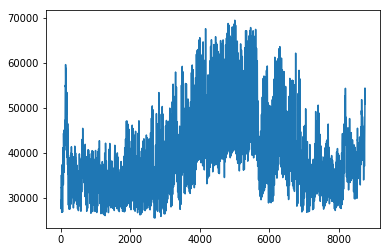

In [4]:
#July peak was calculated to have occured at datetime.datetime(2017, 7, 28, 17, 0)

plt.plot(testloads)
testhours[testloads.argsort()[-5:][::-1]]

In [60]:
print(testloads.argsort()[-5:][::-1])

[5007 5008 5006 4815 4983]


In [5]:
#percentage difference in top two
print(testloads.argsort()[-4:][::-1])
testloads[5007] - testloads[4815] #largest loads exceeds second largest load by 722.3 MW

#average peak was 67,273.1 MW
print(722.3/67273.1) 

#1% of load reduction would result in peak time shift, so I can consider a business using up to approx 700 MW in 2017 without annual peak occuring at some other time

#per ERCOT Day-ahead load forecast error for July was 2.27%

[5007 5008 5006 4815]
0.010736832404036679


In [6]:
#lmps
xls = pd.ExcelFile(path + "LMPS/rpt.00013060.0000000000000000.DAMLZHBSPP_2016.xlsx")
sheets_2016 = ["Jan_1", "Feb_2", "Mar_3", "Apr_4", "May_5", "Jun_6", "Jul_7", "Aug_8", "Sep_9", "Oct_10", "Nov_11", "Dec_12"]
hourly_lmp_2016 = []
for sheet in sheets_2016:
    lmps = pd.read_excel(xls, sheet)
    for i in range(len(lmps['Settlement Point Price'])):
        if lmps['Settlement Point'][i] == 'HB_BUSAVG':
            hourly_lmp_2016.append(lmps['Settlement Point Price'][i])
            
xls = pd.ExcelFile(path + "LMPS/rpt.00013060.0000000000000000.DAMLZHBSPP_2017.xlsx")
sheets_2017 = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
hourly_lmp = []
for sheet in sheets_2017:
    lmps = pd.read_excel(xls, sheet)
    for i in range(len(lmps['Settlement Point Price'])):
        if lmps['Settlement Point'][i] == 'HB_BUSAVG':
            hourly_lmp.append(lmps['Settlement Point Price'][i])
            
hourly_lmp = np.array(hourly_lmp)

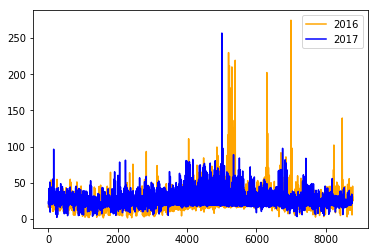

In [7]:
#per megawatt price
plt.plot(hourly_lmp_2016, color="orange", label="2016")
plt.plot(hourly_lmp, color="blue", label="2017")
plt.legend()

In [8]:
#peak lmp's occured 
print(hourly_lmp[[5007, 5008, 5006]])

[206.47  59.55 257.04]


In [44]:
print(testhours[hourly_lmp.argsort()[-5:][::-1]])

NameError: name 'hourly_lmp' is not defined

In [10]:
#concave utility function from 0 to 500 MW
#500 MW at $2150 per MW CP costs = 1.075mil per annum
#maximum daily utility set equal to transmission costs
#17.5(x)(500 - x) - (pi_e + pi_cp)x = y utility
#-17.5x^2 + [8750 - (pi_e + pi_cp)]x = y
#dy/dx = -35x + [8750 - (pi_e + pi_cp)], max x = [8750 - (pi_e + pi_cp)]/35


cp_perMW = 2150.0

In [11]:
def hourly_utility(power, pi_e, pi_cp):
    utility = -17.5*np.power(power, 2) + (8750.0 - (pi_e + pi_cp))*power
    return(utility)

def max_power(pi_e, pi_cp):
    max_pow = (8750.0 - (pi_e + pi_cp))/35.0
    return(max_pow)

def cp_curtailment(cdfval, min_thresh=0.85):
    #returns a fractional curtailment of power demand as a function
    #of predicted CDF value of load
    curtail_val = (cdfval - min_thresh)/(1 - min_thresh)
    outval = np.min([0, curtail_val])
    return(outval)

In [166]:
#perfect knowledge optimal performance during workday

ann_util_opt = 0.0

for i in range(len(testhours)):
    dt = testhours[i]
    if dt.hour in [9, 10, 11, 12, 13, 14, 15, 16]:
        #pi_e = hourly_lmp[i]
        if i == 5007: #CP:
            pi_cp = 2150.0
            mp = max_power(pi_e, pi_cp)
        else:
            pi_cp = 0.0
            mp = max_power(pi_e, pi_cp)

            ann_util_opt += hourly_utility(mp, pi_e, pi_cp)

print(ann_util_opt)

#for each hour
    #calculate max_power, include CP price if annual CP (check that this returns a non-negative value)
    #add utility to annual sum

2919.0


In [6]:
#perfect knowledge optimal performance during workday
#marginal utility model

alphas = np.arange(0.85, 0.999, 0.001)

perfect = []

for a in alphas:
    ann_util_opt = 0.0

    for i in range(len(testhours)):
        dt = testhours[i]
        #if dt.hour in [i for i in range(24)]:
        if dt.hour in [9, 10, 11, 12, 13, 14, 15, 16]:
            if i == 5007: #CP:
                pass
            else:
                ann_util_opt += 1

    perfect.append(ann_util_opt)


In [7]:
#generate historical average model

570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


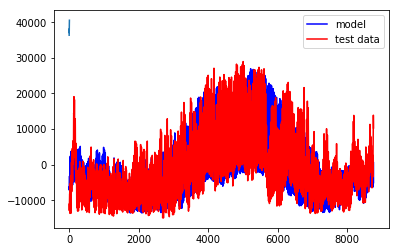

In [8]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]

#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]
    
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue", label="model")
plt.plot(test, color="red", label="test data")
plt.legend()
plt.show()

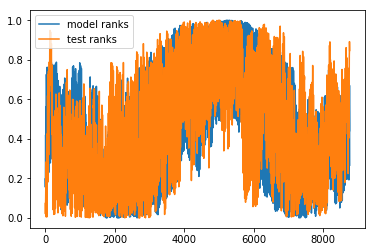

In [10]:
model_ranks = np.zeros((yearly_loads.shape[1], 1))
test_ranks = np.zeros((yearly_loads.shape[1], 1))

for i in range(model_ranks.shape[0]):
    greater = np.sum([ 1 for k in model[:,] if k >= model[i,] ])/float(model.shape[0])
    model_ranks[i,0] = 1.0 - greater
    
for i in range(test_ranks.shape[0]):
    greater = np.sum([ 1 for k in test[:,] if k >= test[i,] ])/float(test.shape[0])
    test_ranks[i,0] = 1.0 - greater
    
plt.plot(model_ranks, label="model ranks")
plt.plot(test_ranks, label="test ranks")
plt.legend()

In [ ]:
for i in range(9,17):
    print(i)

In [ ]:
ann_util = 0.0

for i in day_start_i:
    dt = testhours[i]
    cdf_vals = model_ranks[i:i+24]
    #for h in range(24):
    for h in range(9,17):
        g += 1
        ann_hour = i+h
        pi_e = hourly_lmp[ann_hour]
        mp = max_power(pi_e, 0.0)
        curtail_mp = cp_curtailment(cdf_vals[h])
        rp = curtail_mp * mp
        if ann_hour == 5007:
            #cp occurence
            pi_cp = 2150.0
        else:
            pi_cp = 0.0
            
        ann_util += hourly_utility(rp, pi_e, pi_cp)
        
print(ann_util/ann_util_opt)

In [ ]:
alphas

In [352]:
#marginal utility model
def cp_curtailment(cdfval, min_thresh=0.85):
    #returns a fractional curtailment of power demand as a function
    #of predicted CDF value of load
    curtail_val = (cdfval - min_thresh)/(1 - min_thresh)
    outval = np.nanmax([0, curtail_val])
    return(outval)

historical_by_alpha = []
top_k = 10
top_i = testloads.argsort()[-top_k:][::-1]

for a in alphas:
    ann_util = 0.0

    for i in day_start_i:
        dt = testhours[i]
        if dt.weekday() == 5 or dt.weekday() == 6:
            pass
        #for h in range(24):
        else:
            cdf_vals = model_ranks[i:i+24]
            for h in range(9,17):
                ann_hour = i+h
                curtail_mp = cp_curtailment(cdf_vals[h], min_thresh=a)
                if ann_hour in top_i:
                    ann_util += np.log(1000*(1.01 - curtail_mp)) + (1.0 - curtail_mp)*(-10.0)
                else:
                    ann_util += np.log(1000*(1.01 - curtail_mp))

    #print(ann_util/ann_util_opt)
    historical_by_alpha.append(ann_util)

In [353]:
#lost utility due to curtailment

lost_historical_by_alpha = []

for a in alphas:
    ann_util = 0.0

    for i in day_start_i:
        dt = testhours[i]
        cdf_vals = model_ranks[i:i+24]
        #for h in range(24):
        for h in range(9,17):
            ann_hour = i+h
            curtail_mp = 1.0 - cp_curtailment(cdf_vals[h], min_thresh=a)
            ann_util += curtail_mp
            
            if ann_hour == 5007:
                peak = cdf_vals[h]
            #    ann_util += curtail_mp*(100)
            #else:
            #    ann_util += curtail_mp

    #print(ann_util/ann_util_opt)
    lost_historical_by_alpha.append(ann_util)
print(peak)

[0.9859589]


In [363]:
#neural net model
#with weather data
def torch_reshape_data(databatch):
    #flattens array inputs for a single list of training, target pairs
    inputs = []
    labels = []
    for sample in databatch:
        inputs.append(sample[0].flatten())
        labels.append(sample[1].flatten())
    return(torch.Tensor(np.asarray(inputs)), torch.Tensor(np.asarray(labels)))

path = "/home/chase/projects/peakload/data/nets/models/"
#mname = 'triple_hidden_1903.pt'
mname = 'triple_hidden_3224.pt'
#mname = 'triple_hidden_3080.pt'
#mname = 'triple_hidden_3120.pt' #L1 weather loss
#mname = 'triple_hidden_6772.pt' #load data only

sys.path.append("/home/chase/projects/peakload/src/python/nets/triple_hidden")

nnmodel = torch.load(path + mname)

random.seed(45) #fixed for all experiments, my high school football jersey number
torch.manual_seed(45)

#test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/regional_formatted/load_features/test"#
test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/regional_formatted/load_features_wplus/test"
#test_data_path = "/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/test"
files = os.listdir(test_data_path)
weather_normed_test_data_pairs = []

for i in range(8735):
    fname = str(i) + "_all_weather_load_features.pck"
    with open(test_data_path + "/" + fname, 'rb') as d:
        weather_normed_test_data_pairs.append(pickle.load(d))

In [364]:
day_pairs = []

for i in day_start_i:
    try:
        day_pairs.append(weather_normed_test_data_pairs[i])
    except:
        pass

In [365]:
#do prediction on test data
inputs, labels = torch_reshape_data(day_pairs)
labels = Variable(labels.cuda())
inputs = Variable(inputs.cuda())
outputs = nnmodel(inputs)
    
labels = labels.data.cpu().numpy()
outputs = outputs.data.cpu().numpy()
inputs = inputs.data.cpu().numpy()

RuntimeError: size mismatch at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/THC/generic/THCTensorMathBlas.cu:243

In [307]:
outputs.shape

(364, 24)

In [308]:
labels.shape

(364, 24)

In [214]:
nn_ann_util = 0.0
hourly_utils = []

j = 0
for i in day_start_i:
    dt = testhours[i]
    if dt.weekday() == 5 or dt.weekday() == 6
    if j == 364:
        break
    cdf_vals = outputs[j,:]
    #for h in range(24):
    for h in range(9,17):
        ann_hour = i+h
        pi_e = hourly_lmp[ann_hour]
        mp = max_power(pi_e, 0.0)
        curtail_mp = cp_curtailment(cdf_vals[h])
        rp = curtail_mp * mp
        if ann_hour == 5007:
            #cp occurence
            pi_cp = 2150.0
        else:
            pi_cp = 0.0
            
        nn_ann_util += hourly_utility(rp, pi_e, pi_cp)
        hourly_utils.append(hourly_utility(rp, pi_e, pi_cp))
    j += 1

print((nn_ann_util + 24*np.mean(hourly_utils))/ann_util_opt)

SyntaxError: invalid syntax (<ipython-input-214-d1658d0aabb8>, line 7)

In [354]:
x = []
y = []
pairs = []

for i in range(outputs.shape[0]):
    daystart = i*24
    if i == 364:
        break
    cdf_vals = outputs[i,:]
    powers = testloads[daystart:daystart+24,]
    
    #x.append(powers)
    #y.append(cdf_vals)
    
    for k in range(len(powers)):
        x.append(powers[k])
        y.append(cdf_vals[k])
    #    pairs.append((powers[k],cdf_vals[k]))

In [355]:
len(x)

8736

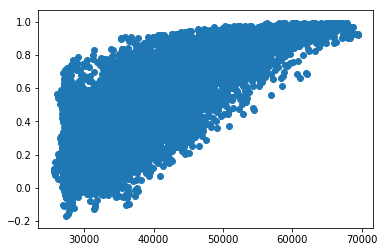

In [356]:
plt.scatter(x,y)

In [357]:
#marginal utility model

nn_by_alpha = []

for a in alphas:
    nn_ann_util = 0.0

    j = 0
    for i in day_start_i:
        dt = testhours[i]
        if j == 364:
            nn_ann_util += 1
            break
        if dt.weekday() == 5 or dt.weekday() == 6:
            pass
        else:
            cdf_vals = outputs[j,:]
            #for h in range(24):
            for h in range(9,17):
                ann_hour = i+h
                curtail_mp = cp_curtailment(cdf_vals[h], min_thresh=a)
                if curtail_mp < 0.0:
                    curtail_mp = 0.0
                    #print("over")
                if ann_hour in top_i:
                    nn_ann_util += np.log(1000*(1.01 - curtail_mp)) + (1.0 - curtail_mp)*(-10.0)
                else:
                    nn_ann_util += np.log(1000*(1.01 - curtail_mp))
                if ann_hour == 5007:
                    peak = cdf_vals[h]

        j += 1

    nn_by_alpha.append(nn_ann_util)
print(peak)
    #print(nn_ann_util/ann_util_opt)

0.9256468


In [358]:
#lost marginal utility model

lost_nn_by_alpha = []

for a in alphas:
    nn_ann_util = 0.0
    hourly_utils = []

    j = 0
    for i in day_start_i:
        dt = testhours[i]
        if j == 364:
            nn_ann_util += 1
            break
        cdf_vals = outputs[j,:]
        #for h in range(24):
        for h in range(9,17):
            ann_hour = i+h
            curtail_mp = 1.0 - cp_curtailment(cdf_vals[h], min_thresh=a)
            nn_ann_util += curtail_mp
            if curtail_mp < 0.0:
                curtail_mp = 0.0
                #print("over")
            #if ann_hour == 5007:
            #    nn_ann_util += curtail_mp*(-0.1)
            #else:
            #    nn_ann_util += curtail_mp

        j += 1

    lost_nn_by_alpha.append(nn_ann_util)
    #print(nn_ann_util/ann_util_opt)

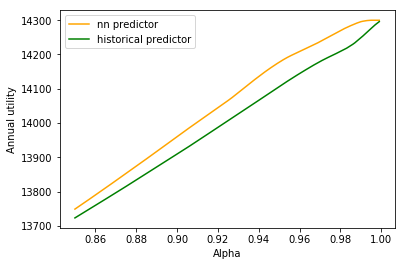

In [359]:
#plt.plot(alphas, perfect, color="blue", label="perfect predictor")
plt.plot(alphas, nn_by_alpha, color="orange", label="nn predictor")
plt.plot(alphas, historical_by_alpha, color="green", label="historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Annual utility")
#plt.ylim(0,3500)
#plt.xlim(0.98,1)

plt.legend()

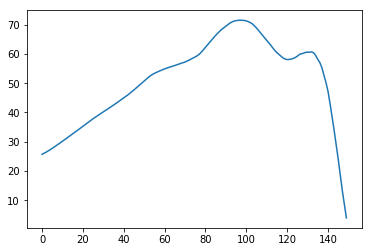

In [360]:
plt.plot(np.array(nn_by_alpha) - np.array(historical_by_alpha))

In [362]:
print(np.array(nn_by_alpha) - np.array(historical_by_alpha))

[25.70775034 26.06093978 26.43990744 26.85828866 27.30310428 27.74957152
 28.22058032 28.7002043  29.1731564  29.66392734 30.1671097  30.66960788
 31.17865481 31.68671896 32.19748392 32.70205806 33.2138889  33.72638861
 34.23314771 34.75631488 35.29514204 35.83084704 36.35046628 36.87845688
 37.38315822 37.86138304 38.34396534 38.81321514 39.27610677 39.7332678
 40.1848485  40.63859006 41.10706538 41.58264344 42.05383449 42.51514961
 42.98647575 43.49662526 43.98706073 44.48092351 44.9830673  45.47101217
 45.98512361 46.54698798 47.11394487 47.70535702 48.29732673 48.89049344
 49.49232422 50.12197964 50.74939391 51.36173961 51.95736547 52.49816193
 52.96331737 53.35285972 53.69283944 53.99248255 54.30504425 54.59660194
 54.86843876 55.1230985  55.36475599 55.56433635 55.79923292 56.04682165
 56.27227924 56.51122849 56.75916015 56.97982338 57.22442884 57.54073855
 57.87869855 58.26140191 58.62056977 58.95599892 59.38017092 59.90489313
 60.60866566 61.39167097 62.23004762 63.07322041 63.

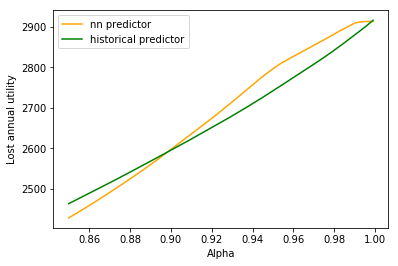

In [361]:
#plt.plot(alphas, perfect, color="blue", label="perfect predictor")
plt.plot(alphas, lost_nn_by_alpha, color="orange", label="nn predictor")
plt.plot(alphas, lost_historical_by_alpha, color="green", label="historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Lost annual utility")
#plt.ylim(2000,3500)

plt.legend()

In [ ]:
#plt.plot(alphas, perfect, color="blue", label="perfect predictor")
plt.plot(alphas, (np.array(nn_by_alpha)/np.array(perfect))*100, color="orange", label="nn predictor")
plt.plot(alphas, (np.array(historical_by_alpha)/np.array(perfect))*100, color="green", label="historical predictor")
plt.xlabel("Alpha")
plt.ylabel("Percentage of perfect predictor")
#plt.ylim(80,100)
plt.xlim(0.9, 1)
plt.legend()

In [65]:
np.array(nn_by_alpha) - np.array(historical_by_alpha)

array([249.88909093, 248.70542643, 247.53991739, 246.40187252,
       245.26557466, 244.1176187 , 242.96030237, 241.81014229,
       240.66317493, 239.51545449, 238.38006868, 237.22752628,
       236.0811546 , 234.94072329, 233.79810296, 232.67254262,
       231.54755632, 230.41701493, 229.27281633, 228.13402882,
       227.00066893, 225.85164095, 224.6951766 , 223.5364547 ,
       222.36024163, 221.15765479, 219.94471586, 218.72085253,
       217.49800152, 216.2607742 , 215.00374555, 213.74481486,
       212.48391755, 211.20301108, 209.93531542, 208.69043356,
       207.42421406, 206.15111644, 204.89534741, 203.64868856,
       202.38150429, 201.08911674, 199.76312946, 198.44603246,
       197.12473945, 195.81352429, 194.50985728, 193.1995915 ,
       191.87215642, 190.52941743, 189.18047   , 187.85001662,
       186.54161169, 185.19123631, 183.81997632, 182.44507711,
       181.02232936, 179.56681436, 178.10344512, 176.58058759,
       175.01847476, 173.4760858 , 171.92417863, 170.34

In [28]:
alphas

array([0.85 , 0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 ,
       0.895, 0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935,
       0.94 , 0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 ,
       0.985, 0.99 , 0.995])